# Setup inicial

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

from IPython.display import HTML, display
from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import graphviz
from sklearn.tree import export_graphviz

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import category_encoders as ce

from src.creditapp.data.raw_data_access import get_application_record

# Loading data

In [2]:
df_clients = get_application_record()

df_clients.drop(['id'], axis=1, inplace=True)

print('data loading was successfully...')

data loading was successfully...


<img src="https://av.sc.com/in/content/images/in-credit-card-banner-1600x490px.jpg" />

# Experiments

**Fecha de creación: 13/05/2020**

**Autores: Santiago Porchietto, Agustín Trulli**

El objetivo del presente cuaderno es la realización de multiples experimentos involucrando modelos de Machine Learning en función de determinar cual es el que mejor funciona para esta problemática en particular.

Como se menciona en el análisis anterior, se busca predecir si una persona incurrirá en incumplimiento de sus deudas contraidas mediante tarjeta de crédito. Para esto creamos la columna target (y).

Todas las features que quedaron en el dataset (menos el id) posterior al preprocessing serán utilizadas como entradas (X).

<u>Metricas a utilizar</u>:

* Precission: Para poder determinar que porcentaje de las veces que dijimos positivo acertamos la predicción. Por si sola es insuficiente (Encontramos 2 positivos que realmente lo son (100% de precission), en un dataset que posee 1000 positivos).

* Recall: Para complementar precission, nos va a decir el porcentaje de positivos que encontramos por sobre los reales.

* F1-Score: Como métrica que combina las anteriores.

Con nuestro ejemplo en particular, precission es la métrica que más deberíamos mirar, ya que, en función de las políticas que tome el banco contra los deudores, tendríamos que estar bastante seguros de que una persona lo es antes de etiquetarla de ello.

<u>Modelos a evaluar</u>:

* Decission Tree 

* Random Forest

* Logistic Regression

* K Nearest Neighbors (KNN)

* Gradient Boosted Trees

* Neural Networks (MLP)

## Feature Engineering

Debido a la contextura de nuestro dataset, que posee varias features de tipo boolean, no es posible realizar feature engineering a gran escala. Para emplear alguna de las técnicas vistas, realizamos el armado de rangos sobre features non-categorical altamente variables.

Por su parte, las features categóiricas no parecen evidenciar información oculta a extraer. 

### Months employed
Armado de los rangos de meses trabajados para "agrupado de valores similares" y reducción de variabilidad.

In [3]:
# parentesis no incluye el término
# corchete incluye el término

# Bajo la suposición de que estas personas nunca trabajaron o se encuentran este periodo de tiempo sin trabajar.
# Se debería consultar con el "cliente/banco", pero tiene sentido.
df_clients["months_employed"].fillna(0, inplace = True)

df_clients.loc[::, 'months_employed_range'] = pd.cut(df_clients.months_employed, 
                                                     list(range(0, 205, 6)), include_lowest='True')

df_clients['months_employed_range'] = df_clients['months_employed_range'].astype(str)
df_clients.loc[df_clients.months_employed_range == 'nan', 'months_employed_range'] = np.nan
df_clients.loc[df_clients.months_employed_range == '(-0.001, 6.0]', 'months_employed_range'] = '[0.0, 6.0]'
df_clients.loc[df_clients.months_employed >= 205, 'months_employed_range'] = '(204.0, 524.0]'

### Income total
Armado de los rangos de ingresos para "agrupado de valores similares" y reducción de variabilidad.

In [4]:
# parentesis no incluye el término
# corchete incluye el término

df_clients.loc[::, 'amt_income_range'] = pd.cut(df_clients.amt_income_total, 
                                               list(range(27000, 300001, 14325)), include_lowest='True')

df_clients['amt_income_range'] = df_clients['amt_income_range'].astype(str)
df_clients.loc[df_clients.amt_income_range == '(26999.999, 41325.0]', 'amt_income_range'] = '[27000.0, 41325.0]'
df_clients.loc[df_clients.amt_income_total > 300000, 'amt_income_range'] = '(300000.0, 1575000.0]'

## Utils

In [5]:
def evaluate_model(model, set_names=('train', 'test', 'validation'), title='', show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'test', 'validation']
        set_data = globals()[set_name] 

        y = set_data.target
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Greens', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['no deudor', 'deudor'])
            ax.yaxis.set_ticklabels(['no deudor', 'deudor'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

In [6]:
def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['no deudor', 'deudor'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
        max_depth=3,
    )
    graph = graphviz.Source(graph_data)  
    return graph

In [7]:
def get_best_scores(grid_search):
    print('-----------------------------------------------------------------------------------------')
    print('Mejor score (F1): ', round(grid_search.best_score_, 5))
    print('Mejores parámetros: \n', grid_search.best_params_)
    print('-----------------------------------------------------------------------------------------')

In [8]:
def get_model_results(i, experiments):
    for grid_search, pipe in experiments:
        i += 1
        evaluate_model(pipe, title=f'Experiment {i}')
        get_best_scores(grid_search)

## Generating test, train & validation sets 
Decidimos utilizar el 70% del dataset para train (6618 registros) y el 30% restante para test y validation (1418 para cada uno).

In [9]:
# Test, train & validation sets
train, not_train = train_test_split(df_clients, test_size=0.3, random_state=1)
validation, test = train_test_split(not_train, test_size=0.5, random_state=1)

print('data generating was successfully...')

data generating was successfully...


## Mapper

In [10]:
mapper = DataFrameMapper([
    (['code_gender'], [ce.OneHotEncoder()]),
    (['flag_own_car'], [ce.OneHotEncoder()]),
    (['flag_own_realty'], [ce.OneHotEncoder()]),
    (['cnt_children'], [StandardScaler()]),
    (['name_income_type'], [ce.WOEEncoder()]),
    (['name_education_type'], [ce.WOEEncoder()]),
    (['name_family_status'], [ce.WOEEncoder()]),
    (['name_housing_type'], [ce.WOEEncoder()]),
    (['months_employed_range'], [ce.WOEEncoder()]),
    (['amt_income_range'], [ce.WOEEncoder()]),
    (['occupation_type'], [ce.WOEEncoder()]),
    (['cnt_fam_members'], [StandardScaler()]),
    (['age'], [StandardScaler()]),
    (['flag_mobil'], None),
    (['flag_work_phone'], None),
    (['flag_email'], None),
    (['flag_phone'], None)
])

<u> Los criterios para el armado del mapper fueron los siguientes</u>:

* Se realizó el scaling de la cantidad de hijos, la cantidad de miembros de la familia y la edad, ajustándola a una distribución con media 0 y desvío estándar 1.

* Para features binarias y categóricas de poca "variabilidad" tales como el género o si la persona posee auto utilizamos OneHotEncoder.

* Para features categóticas con un rango de valores mayor tales como el tipo de ocupación o el tipo de vivienda, utilizamos Weight of Evidence Encoding (WOEE). Este método fue desarrollado principalmente para construir un modelo predictivo para evaluar el riesgo de incumplimiento de préstamos en la industria crediticia y financiera.

Se basa en una medida de cuánto la evidencia apoya o socava una hipótesis. Se calcula en función de:

<img src=https://4.bp.blogspot.com/-X1m0w40w0xg/V9V_7LS1AQI/AAAAAAAAFWc/f4bgPvE1In8Q13kGGBghp98MeWma8KgqACLcB/s1600/woe.png>

<u>Donde</u>:

* Distribution of Goods: Registros que cumplen con el target (pagaron, "buenos clientes").
* Distribution of Bads: Registros que no cumplen con el target (no pagaron, "malos clientes").

<u> Interpretación</u>:

**WOE va a ser 0 si P(GOOD)/P(BAD) = 1 (iguales).**
**WOE va a ser menor a 0 si P(GOOD) < P(BAD) (La razon de probabilidad entre ambas será menor a 1). Menos chances de cumplir.**
**WOE va a ser mayor a 0 si P(GOOD) > P(BAD) (La razon de probabilidad entre ambas será mayor a 1). Mas chances de cumplir.**

<u>Además</u>:

<img src="https://miro.medium.com/max/600/1*9Gi0fGyTpxfwM2TpV4GZQQ.png" width="300" height="50">



<img src=https://miro.medium.com/max/578/1*5S_5aAHWe0_knDGZUK3W8w.png width="300" height="200">

*see more: http://contrib.scikit-learn.org/category_encoders/woe.html*

## Models

### Decission Tree

In [11]:
def get_tree_config(max_depths=[None], min_samples_split=[2], min_samples_leaf=[1]):
    params = {
            'max_depth': max_depths,
            'criterion': ['entropy', 'gini'],
            'class_weight': [{0: 1, 1: 8}, 'balanced'],
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }
    
    model = DecisionTreeClassifier(random_state=1)
    
    return model, params

In [12]:
def make_tree_predictions(model, parameters):
    grid_search_tree = GridSearchCV(model, parameters, 
                                scoring='f1', verbose=1)

    pipe_tree = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_tree),
    ])

    pipe_tree.fit(train, train.target)
    
    return pipe_tree, grid_search_tree

In [13]:
model_1, parameters_1 = get_tree_config(max_depths=[5,6,7], 
                                        min_samples_split=[80,100], 
                                        min_samples_leaf=[10,15,20,30])

model_2, parameters_2 = get_tree_config(max_depths=[9,10,11], 
                                        min_samples_split=[80,100], 
                                        min_samples_leaf=[10,15,20,30])

model_3, parameters_3 = get_tree_config(max_depths=[5,6,7,9,10,11])

model_4, parameters_4 = get_tree_config(max_depths=[5,6,7], 
                                        min_samples_split=[80,100,130,170], 
                                        min_samples_leaf=[15,20,30,40,50])

model_5, parameters_5 = get_tree_config(max_depths=[5,6,7], 
                                        min_samples_split=[60,70,80,100,130], 
                                        min_samples_leaf=[30,40,50,65,90])

pipe_tree_1, grid_search_tree_1 = make_tree_predictions(model_1, parameters_1)
pipe_tree_2, grid_search_tree_2 = make_tree_predictions(model_2, parameters_2)
pipe_tree_3, grid_search_tree_3 = make_tree_predictions(model_3, parameters_3)
pipe_tree_4, grid_search_tree_4 = make_tree_predictions(model_4, parameters_4)
pipe_tree_5, grid_search_tree_5 = make_tree_predictions(model_5, parameters_5)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   11.8s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   17.3s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.3s finished


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   29.3s finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   42.5s finished


**Results**

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.439861,0.110207,0.820183,0.194306
test,0.436927,0.106236,0.786325,0.187182
validation,0.392102,0.072645,0.587156,0.129293


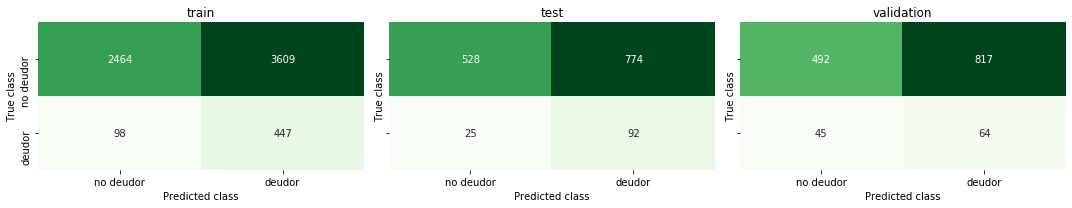

-----------------------------------------------------------------------------------------
Mejor score (F1):  0.18127
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 100}
-----------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.528407,0.127746,0.811009,0.220724
test,0.516561,0.113976,0.717949,0.196721
validation,0.458392,0.078105,0.559633,0.137079


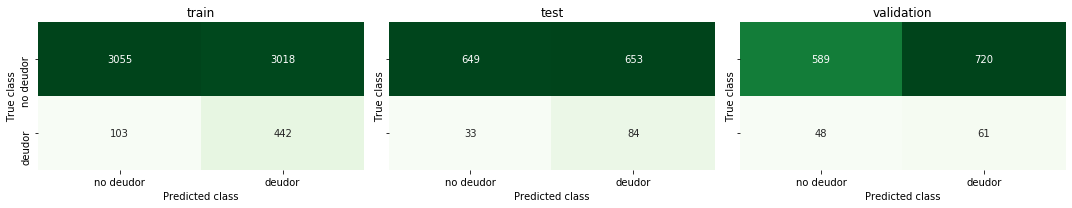

-----------------------------------------------------------------------------------------
Mejor score (F1):  0.17983
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 100}
-----------------------------------------------------------------------------------------


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.443941,0.112101,0.831193,0.197558
test,0.439746,0.106729,0.786325,0.187947
validation,0.394922,0.072976,0.587156,0.129817


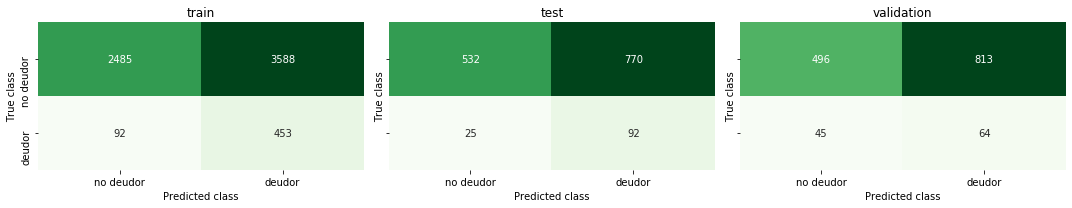

-----------------------------------------------------------------------------------------
Mejor score (F1):  0.17969
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
-----------------------------------------------------------------------------------------


'Experiment 4'

,Accuracy,Precision,Recall,F1
train,0.480508,0.117024,0.811009,0.204535
test,0.469345,0.105459,0.726496,0.184182
validation,0.435120,0.082126,0.623853,0.145144


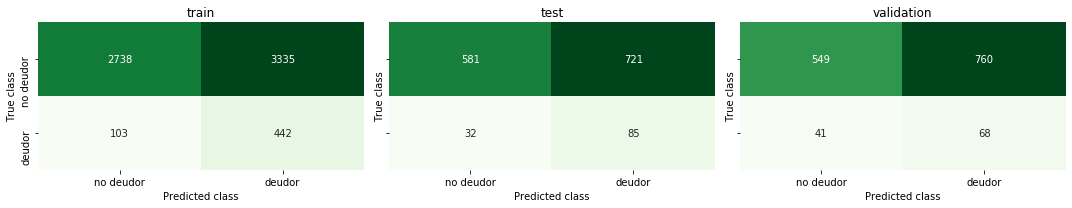

-----------------------------------------------------------------------------------------
Mejor score (F1):  0.18392
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 80}
-----------------------------------------------------------------------------------------


'Experiment 5'

,Accuracy,Precision,Recall,F1
train,0.480508,0.117024,0.811009,0.204535
test,0.469345,0.105459,0.726496,0.184182
validation,0.435120,0.082126,0.623853,0.145144


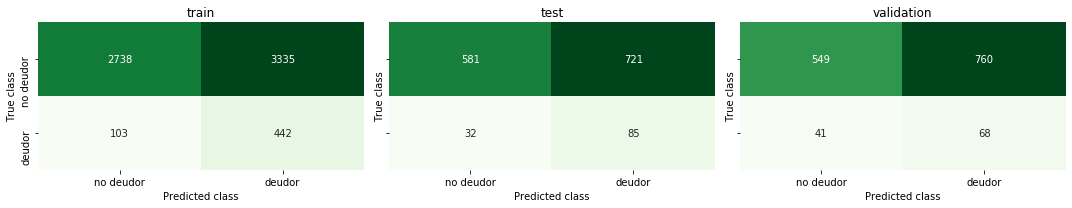

-----------------------------------------------------------------------------------------
Mejor score (F1):  0.18392
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 60}
-----------------------------------------------------------------------------------------


In [14]:
i = 0
experiments = [(grid_search_tree_1, pipe_tree_1), 
               (grid_search_tree_2, pipe_tree_2), 
               (grid_search_tree_3, pipe_tree_3), 
               (grid_search_tree_4, pipe_tree_4), 
               (grid_search_tree_5, pipe_tree_5)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

En función de los resultados podemos determinar que la config de modelo que más se ajusta a nuestro problema es la referente al *experimento 2*, ya que, como mencionamos en un principio, precission va a tener un mayor peso debido a las "represarias" que se podrían tomar contra un cliente clasificado erroneamente como deudor. A costa de esta decisión estariamos disminuyendo la probabilidad de encontrar casos positivos (leve caida de recall), pero esta pérdida es practicamente despreciable.

Es por ello que es recomendable pactar reuniones con el cliente, para que de esta forma se pueda establecer un trade-off acorde a las necesidades del negocio.

Es importante tener en cuenta que al tomar un "min_samples_leaf" de 30 se podría dar el caso de etiquetar como deudor a una persona en funcion de  un nodo hoja con 30 samples clasificados como deudores. Deberíamos verificar con el cliente en base a los criterios organizacionales que tan correcta es esta postura de generalización.

Por otra parte, los scores alcanzados por los demás experimentos tampoco difieren mucho de los resultados alcanzados por la config elegida (aprox. 1% en F1 score). Por lo tanto, llegamos a la conclusión de que el tunning de hiperparámetros no va a tener un impacto significativo en los resultados finales (como sí lo haría conseguir más datos, realizar más feature engeneering, etc).

<u>Arbol del experimento 2</u>:

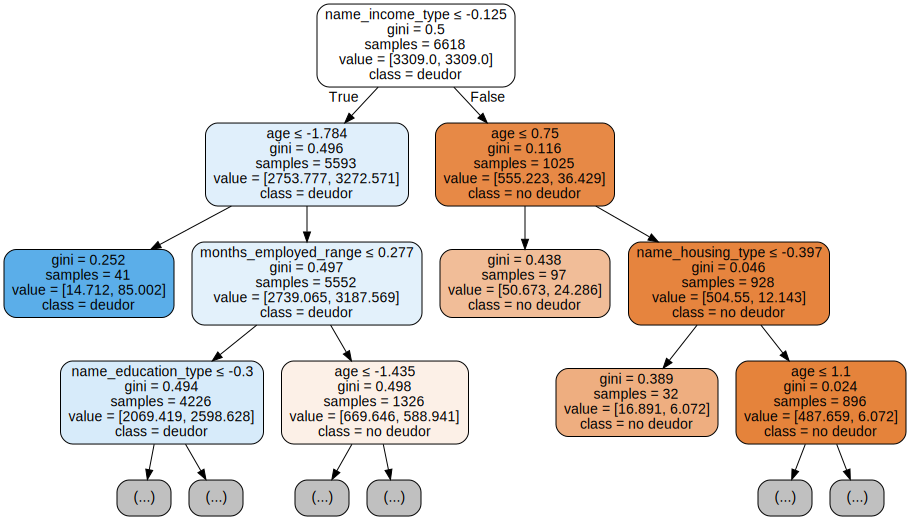

In [15]:
graph_tree(grid_search_tree_2.best_estimator_, mapper.transformed_names_)

<u>Resultados de los experimentos</u>:
* Solo el 11% de las veces que el arbol dijo 1 (deudor) acertó a la predicción.
* No obstante, es capaz de encontrar entre el 72% y el 78% de los deudores (en función de la config).
* Esto nos lleva a pensar que el modelo esta clasificando muchas veces como deudor a clientes que, en realidad, no lo son.
* Debido a la amplia diferencia entre estas métricas, la mejor configuración para este modelo nos arroja un F1 de apenas  ≈0.20.

### Random Forest

In [16]:
def get_forest_config(estimators=[100], max_depths=[None], min_samples_split=[2], min_samples_leaf=[1]):
    params = {
            'n_estimators': estimators,
            'max_depth': max_depths,
            'criterion': ['entropy', 'gini'],
            'class_weight': [{0: 1, 1: 8}, 'balanced'],
            'n_jobs': [-1],
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }
    
    model = RandomForestClassifier(random_state=1)
    
    return model, params

In [17]:
def make_forest_predictions(model, parameters):
    grid_search_forest = GridSearchCV(model, parameters, 
                                      scoring='f1', verbose=1)

    pipe_forest = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_forest),
    ])

    pipe_forest.fit(train, train.target)
    
    return pipe_forest, grid_search_forest

In [18]:
model_1, parameters_1 = get_forest_config(max_depths=[5,6,7],
                                          estimators=[100,200,300],
                                          min_samples_split=[80,100], 
                                          min_samples_leaf=[10,15,20,30])

model_2, parameters_2 = get_forest_config(max_depths=[9,10,11],
                                          estimators=[100,200,300],
                                          min_samples_split=[80,100], 
                                          min_samples_leaf=[10,15,20,30])

pipe_forest_1, grid_search_forest_1 = make_forest_predictions(model_1, parameters_1)
pipe_forest_2, grid_search_forest_2 = make_forest_predictions(model_2, parameters_2)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 24.1min finished


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 26.6min finished


**Results**

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.457389,0.120956,0.891743,0.213018
test,0.434813,0.109464,0.820513,0.193159
validation,0.399859,0.079365,0.642202,0.141271


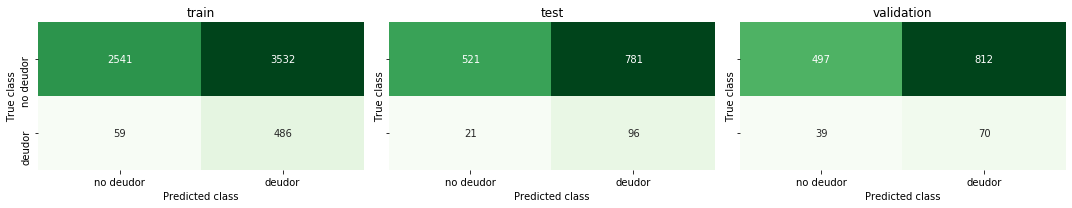

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.18325
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 300, 'n_jobs': -1}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.723330,0.210099,0.855046,0.337315
test,0.648344,0.110204,0.461538,0.177924
validation,0.638928,0.087935,0.394495,0.143813


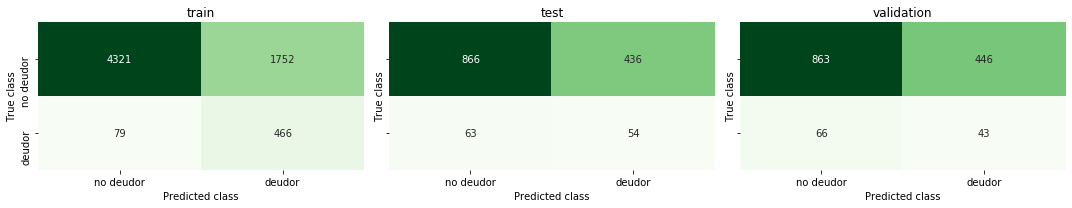

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.17393
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 300, 'n_jobs': -1}
----------------------------------------------------------------------------------------------------------------------------


In [45]:
i=0
experiments = [(grid_search_forest_1, pipe_forest_1), 
               (grid_search_forest_2, pipe_forest_2)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

Las 2 configs ejecutadas difieren en la profundidad utilizada por los trees de los que se compone el modelo. En la primera de estas, podemos ver como se obtiene un mayor recall, esto debido a que el modelo clasifica muchas veces como deudores a personas que en realidad no lo son. En otras palabras, somos capaces de encontrar muchos casos de personas deudoras a costa de una gran disminucion del porcentaje encontrado de personas no deudoras.

Por su parte, la segunda config pierde en recall score, pero tiene un menor "efecto colateral" relacionado a clasificar como deudores a personas que pagan en regla. Es decir, aumentaremos nuestra probabilidad de encontrar casos "no deudores" a costa de encontrar menos "deudores".

Todo esto deberia ser tratado con el cliente para determinar la mejor decision de acuerdo con las politicas de la empresa.

En función de lo dicho, vamos a probar el tunning de *min_samples_leaf* para la configuración que mejor performance tuvo (experimento 2 teniendo en cuenta el menor impacto provocado en los casos de personas no deudoras), para ver como se comporta al tener que determinar nodos hoja con una mayor cantidad de samples. 

In [20]:
model_3, parameters_3 = get_forest_config(max_depths=[9,10,11],
                                          estimators=[100,200,300],
                                          min_samples_split=[80], 
                                          min_samples_leaf=[30,40,50,60])

pipe_forest_3, grid_search_forest_3 = make_forest_predictions(model_3, parameters_3)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 12.3min finished


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.635539,0.164571,0.840367,0.275240
test,0.574348,0.107890,0.572650,0.181572
validation,0.551481,0.079745,0.458716,0.135870


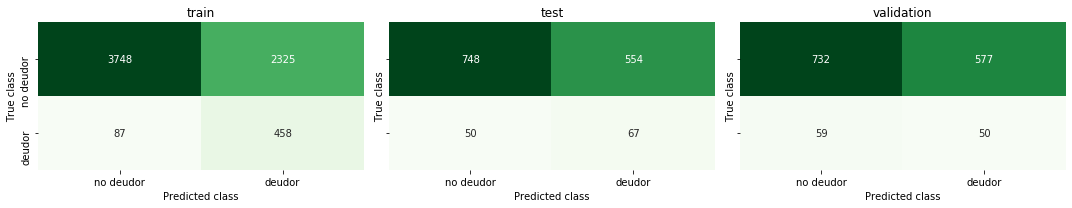

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.17623
Mejores parámetros: 
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 50, 'min_samples_split': 80, 'n_estimators': 300, 'n_jobs': -1}
----------------------------------------------------------------------------------------------------------------------------


In [46]:
i=2
experiments = [(grid_search_forest_3, pipe_forest_3)]

get_model_results(i, experiments)

Se puede obervar aumento del 11% en recall, manteniendo el mismo precission del 11%, pero a costa de un aumento del impacto negativo nombrado anteriormente. Es decir, somos capaces de enontrar mas casos positivos (deudores), pero menos casos negativos (no deudores).

En conclusión, en base a los resultados obtenidos, debemos determinar con el cliente cual es el trade-off entre un buen precission y un buen recall, ya que, en esta ultima config pudimos observar que, al aumentar el numero de *min_samples_leaf* el modelo elige quedarse con una profundidad menor, debido que la cantidad de samples para que un nodo sea considerado hoja es mayor, y realiza menos cortes.

Más allá de lo mencionado, creemos que el experimento 3 es el mas indicado, debido a que es el que mantiene una relacion mas balanceada entre los positivos encontrados y los negativos.

<u>Resultados</u>:
* Solo el ≈11% de las veces que el arbol dijo 1 (deudor) acertó a la predicción.
* En esta ocasión, es capaz de encontrar el ≈57% de los deudores.
* Esto nos lleva a penar, que a diferencia del decission tree, el forest esta diciendo "esta persona será deudor" en una proporción menor al total.
* Debido a la diferencia entre estas métricas, la mejor configuración para random forest nos arroja un F1 de apenas  ≈0.18.

### Logistic Regression

In [8]:
def get_logistic_regression_config(max_iters=[100]):
    params = {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.1, 1, 0.5],
            'max_iter': max_iters,
            'class_weight': [{0: 1, 1: 8}, 'balanced'], 
            'solver': ['lbfgs', 'liblinear']
        }
    
    model = LogisticRegression(random_state=1)
    
    return model, params

In [9]:
def make_LR_predictions(model, parameters):
    grid_search_lr = GridSearchCV(model, parameters, 
                                  scoring='f1', verbose=1)

    pipe_lr = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_lr),
    ])

    pipe_lr.fit(train, train.target)
    
    return pipe_lr, grid_search_lr

In [10]:
model_1, parameters_1 = get_logistic_regression_config(max_iters=[50,70,90,100])
model_2, parameters_2 = get_logistic_regression_config(max_iters=[10,20,30,40])
model_3, parameters_3 = get_logistic_regression_config(max_iters=[200,300,400])

pipe_lr_1, grid_search_lr_1 = make_LR_predictions(model_1, parameters_1)
pipe_lr_2, grid_search_lr_2 = make_LR_predictions(model_2, parameters_2)
pipe_lr_3, grid_search_lr_3 = make_LR_predictions(model_3, parameters_3)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator 

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scal

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solve

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\User

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   25.4s finished


**Results**

In [11]:
i = 0
experiments = [(grid_search_lr_1, pipe_lr_1), 
               (grid_search_lr_2, pipe_lr_2), 
               (grid_search_lr_3, pipe_lr_3)]

get_model_results(i, experiments)

NameError: name 'evaluate_model' is not defined

<u>Conclusiones generales</u>:

Luego de variar el numero de iteraciónes necesarios para que el *solver* del modelo converja en una solución (100 por default), y, tambíen habiendo incluido el *solver* "liblinear" (recomendado para dataset de pequeñas dimensiones), llegamos a la conclusión de que el modelo logistic regression para nuestro dataset no se verá afectado significativamente por las diferentes combinaciones de hiperparámetros.

En base a ello, cualquiera de estos modelos podría ser útil en función de los resultados generales. A su vez, se puede notar una performance similar a los dos modelos anteriores.

<u>Resultados</u>:
* Solo el 10% de las veces que el modelo dijo 1 (deudor) acertó a la predicción.
* No obstante, es capaz de encontrar el 58% de los deudores.
* Esto significa que está pasando algo similar a los modelos anteriores, el modelo está clasificando muchas veces como deudor a clientes que, en realidad, no lo son.
* Debido a la diferencia existente entre estas métricas, la mejor configuración para la logistic regression nos arroja un F1 de apenas ≈0.17.

### K Nearest Neighbors (KNN)

In [26]:
def get_knn_config(neighbors=[5]):
    params = {
            'n_neighbors': neighbors,
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto'],
            'p': [1, 2],
            'n_jobs': [-1]
        }
    
    model = KNeighborsClassifier()
    
    return model, params

In [27]:
def make_KNN_predictions(model, parameters):
    grid_search_knn = GridSearchCV(model, parameters, 
                                   scoring='f1', verbose=1)

    pipe_knn = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_knn),
    ])

    pipe_knn.fit(train, train.target)
    
    return pipe_knn, grid_search_knn

In [24]:
model_1, parameters_1 = get_knn_config(neighbors=[3,4,5])
model_2, parameters_2 = get_knn_config(neighbors=[5,6,7])
model_3, parameters_3 = get_knn_config(neighbors=[10,15,18])

pipe_knn_1, grid_search_knn_1 = make_KNN_predictions(model_1, parameters_1)
pipe_knn_2, grid_search_knn_2 = make_KNN_predictions(model_2, parameters_2)
pipe_knn_3, grid_search_knn_3 = make_KNN_predictions(model_3, parameters_3)

NameError: name 'get_knn_config' is not defined

**Results**

In [ ]:
i = 0
experiments = [(grid_search_knn_1, pipe_knn_1), 
               (grid_search_knn_2, pipe_knn_2), 
               (grid_search_knn_3, pipe_knn_3)]

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

En los 2 primeros experimentos podemos observar que KNN se queda con el menor número de vecinos posibles (3 y 5 respectivamente). Con estos hiperparámetros ambos modelos estan sobreentrenando, ya que, al comparar las métricas de train y de test, se obserban importantes diferencias en sus valores. Prácticamente memorizó los ejemplos de entrenamiento a tal punto de acertar en todas las predicciones (usando train como conjunto de datos), pero al momento de evaluar la pérformance con test, el sólo alcanza un 16% en precission y un 5% en recall aproximadamente (en el mejor de los casos).

En cambio, en el tercer experimento ocurre justamente lo contrario: si bien toma el menor numero de vecinos disponibles (10), no es capaz de atinar a ninguna de las predicciones positivas (ni con train ni con test). Como se puede observar en accuracy, un 9% de las veces el modelo se equivocó, correspondiente a los "deudores" clasificados como "no deudores". Esto es un claro ejemplo de underfiting.

En función de lo dicho, comprobaremos manualmente con que número de vecinos se produce esta diferenciación:

In [30]:
model_4, parameters_4 = get_knn_config(neighbors=[7])
model_5, parameters_5 = get_knn_config(neighbors=[8])

pipe_knn_4, grid_search_knn_4 = make_KNN_predictions(model_4, parameters_4)
pipe_knn_5, grid_search_knn_5 = make_KNN_predictions(model_5, parameters_5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.2s finished


'Experiment 4'

,Accuracy,Precision,Recall,F1
train,1.000000,1.0,1.0,1.0
test,0.912615,0.0,0.0,0.0
validation,0.921721,0.0,0.0,0.0


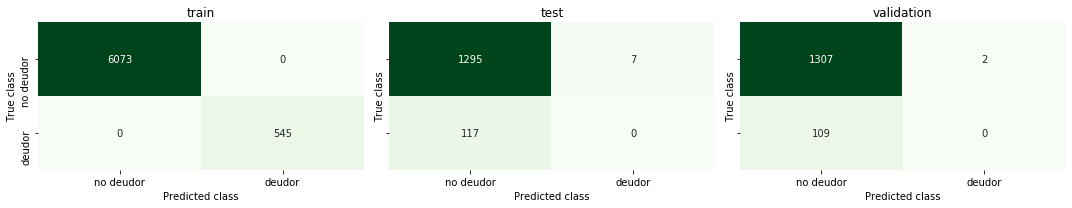

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.00339
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 5'

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
train,0.917649,0.0,0.0,0.0
test,0.917548,0.0,0.0,0.0
validation,0.922426,0.0,0.0,0.0


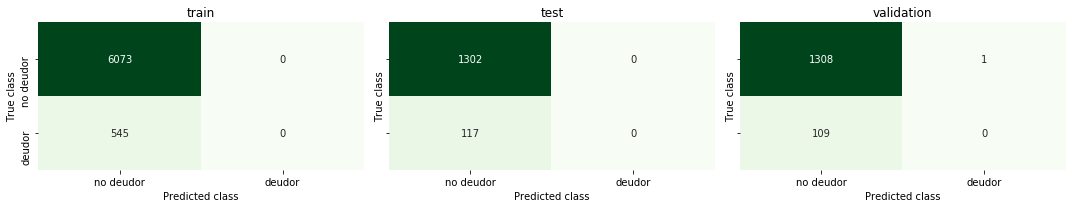

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.0
Mejores parámetros: 
 {'algorithm': 'auto', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
----------------------------------------------------------------------------------------------------------------------------


In [49]:
i = 3
experiments = [(grid_search_knn_4, pipe_knn_4), 
               (grid_search_knn_5, pipe_knn_5)] 

get_model_results(i, experiments)

<u>Mejor modelo: ninguno de ellos</u>

* KNN no es un modelo aplicable a este problema, debido a que con las diferentes combinaciónes testeadas, no es capaz de realizar un training exitoso (overfitea o underfitea).

### Gradient Boosted Trees

In [32]:
def get_gradient_boosting_config(estimators=[100],max_depths=[3], min_samples_splits=[2], min_samples_leafs=[1]):
    params = {
            'n_estimators': estimators,
            'max_depth': max_depths,
            'min_samples_split': min_samples_splits,
            'min_samples_leaf': min_samples_leafs,
            
        }
    
    model = GradientBoostingClassifier(random_state=1)
    
    return model, params

In [33]:
def make_GB_predictions(model, parameters):
    grid_search_gb = GridSearchCV(model, parameters, 
                                   scoring='f1', verbose=1)

    pipe_gb = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_gb),
    ])

    pipe_gb.fit(train, train.target)
    
    return pipe_gb, grid_search_gb

In [34]:
model_1, parameters_1 = get_gradient_boosting_config(estimators=[100, 120, 150],
                                                     max_depths=[5,6,7],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[10,15,20,30])

model_2, parameters_2 = get_gradient_boosting_config(estimators=[100, 120, 150],
                                                     max_depths=[9,10,11],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[10,15,20,30])

pipe_gb_1, grid_search_gb_1 = make_GB_predictions(model_1, parameters_1)
pipe_gb_2, grid_search_gb_2 = make_GB_predictions(model_2, parameters_2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 12.2min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 18.7min finished


In [35]:
model_3, parameters_3 = get_gradient_boosting_config(estimators=[150, 200, 250],
                                                     max_depths=[5,6,7],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[10,15,20,30])

model_4, parameters_4 = get_gradient_boosting_config(estimators=[150, 200, 250],
                                                     max_depths=[9,10,11],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[10,15,20,30])

pipe_gb_3, grid_search_gb_3 = make_GB_predictions(model_3, parameters_3)
pipe_gb_4, grid_search_gb_4 = make_GB_predictions(model_4, parameters_4)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 21.5min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 32.3min finished


In [36]:
model_5, parameters_5 = get_gradient_boosting_config(estimators=[150, 200, 250],
                                                     max_depths=[5,6,7],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[30,40,50])

model_6, parameters_6 = get_gradient_boosting_config(estimators=[150, 200, 250],
                                                     max_depths=[9,10,11],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[30,40,50])

pipe_gb_5, grid_search_gb_5 = make_GB_predictions(model_5, parameters_5)
pipe_gb_6, grid_search_gb_6 = make_GB_predictions(model_6, parameters_6)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 15.9min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 29.8min finished


**Results**

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.938199,1.0,0.249541,0.399413
test,0.915433,0.2,0.008547,0.016393
validation,0.916784,0.0,0.000000,0.000000


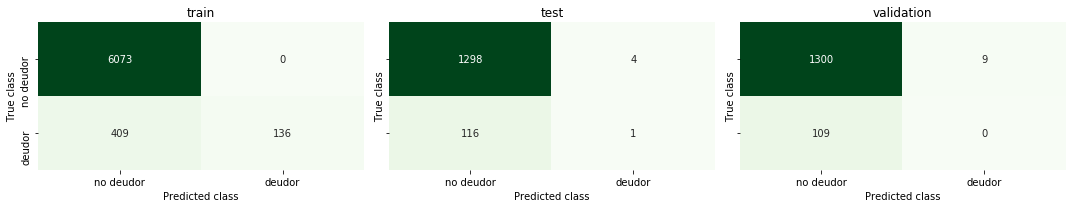

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.02789
Mejores parámetros: 
 {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 150}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.992143,1.000,0.904587,0.949904
test,0.909091,0.125,0.017094,0.030075
validation,0.908322,0.000,0.000000,0.000000


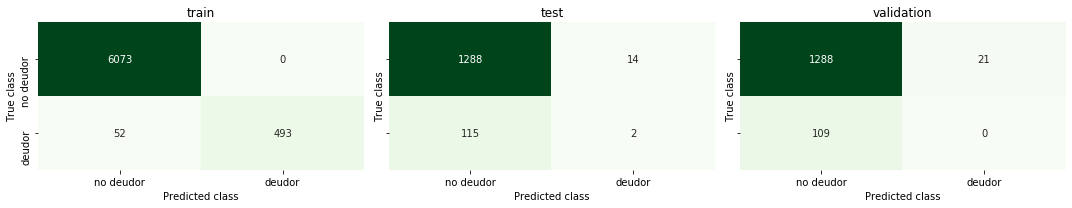

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.03945
Mejores parámetros: 
 {'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 80, 'n_estimators': 150}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.951043,0.995516,0.407339,0.578125
test,0.914729,0.333333,0.034188,0.062016
validation,0.916784,0.000000,0.000000,0.000000


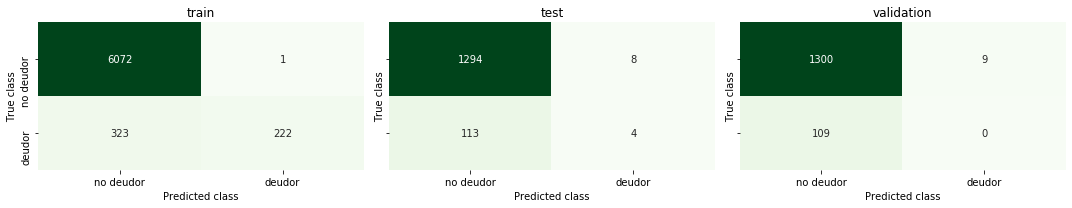

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.04644
Mejores parámetros: 
 {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 80, 'n_estimators': 250}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 4'

,Accuracy,Precision,Recall,F1
train,0.999093,1.000000,0.988991,0.994465
test,0.906977,0.173913,0.034188,0.057143
validation,0.906911,0.000000,0.000000,0.000000


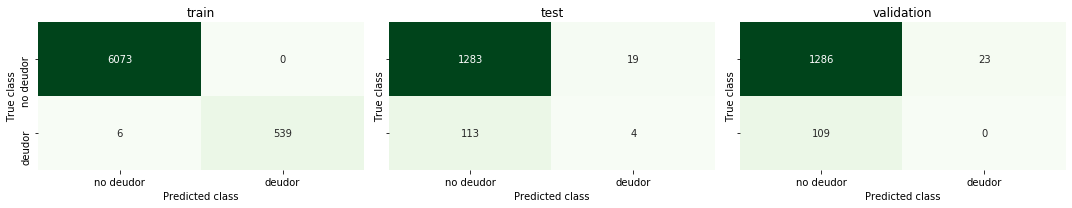

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.05924
Mejores parámetros: 
 {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 80, 'n_estimators': 250}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 5'

,Accuracy,Precision,Recall,F1
train,0.95074,0.995475,0.403670,0.574413
test,0.91191,0.214286,0.025641,0.045802
validation,0.91890,0.200000,0.018349,0.033613


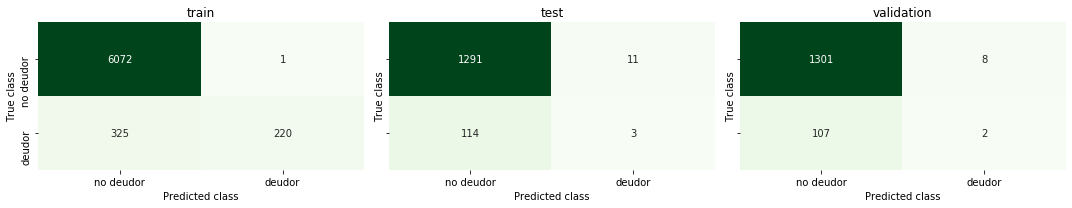

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.02959
Mejores parámetros: 
 {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 80, 'n_estimators': 250}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 6'

,Accuracy,Precision,Recall,F1
train,0.980961,1.000000,0.768807,0.869295
test,0.912615,0.266667,0.034188,0.060606
validation,0.913963,0.066667,0.009174,0.016129


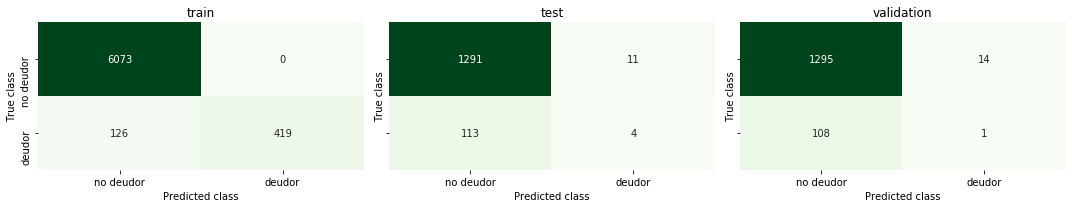

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.03844
Mejores parámetros: 
 {'max_depth': 9, 'min_samples_leaf': 30, 'min_samples_split': 80, 'n_estimators': 200}
----------------------------------------------------------------------------------------------------------------------------


In [50]:
i = 0
experiments = [(grid_search_gb_1, pipe_gb_1), 
               (grid_search_gb_2, pipe_gb_2),
               (grid_search_gb_3, pipe_gb_3),
               (grid_search_gb_4, pipe_gb_4),
               (grid_search_gb_5, pipe_gb_5),
               (grid_search_gb_6, pipe_gb_6)] 

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

Se puede observar que, en general, la pérformance de train es elevada, pero la de test es muy baja. Debido a estas grandes diferencias llegamos a la conslusión de que, con los hiperparametros establecidos, el modelo overfitea. 

Es por ello que decidimos acortar el número de estimadores base, así como también aumentar el número de samples necesarios para que un nodo sea denominado hoja.

In [51]:
model_7, parameters_7 = get_gradient_boosting_config(estimators=[50],
                                                     max_depths=[5,6,7],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[20,30,40])

model_8, parameters_8 = get_gradient_boosting_config(estimators=[50],
                                                     max_depths=[9,10,11],
                                                     min_samples_splits=[80,100], 
                                                     min_samples_leafs=[20,30,40])

pipe_gb_7, grid_search_gb_7 = make_GB_predictions(model_7, parameters_7)
pipe_gb_8, grid_search_gb_8 = make_GB_predictions(model_8, parameters_8)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.5min finished


'Experiment 7'

,Accuracy,Precision,Recall,F1
train,0.919764,1.0,0.025688,0.050089
test,0.917548,0.5,0.008547,0.016807
validation,0.922426,0.0,0.000000,0.000000


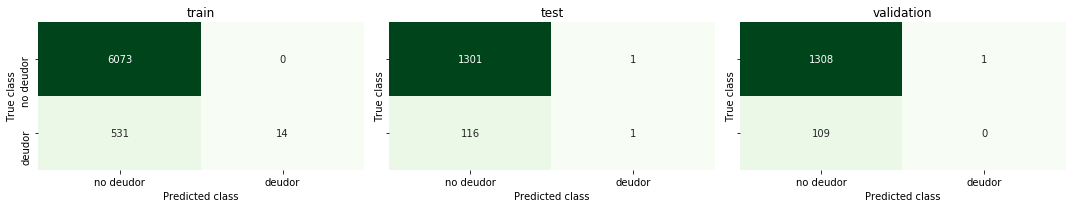

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.00364
Mejores parámetros: 
 {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 80, 'n_estimators': 50}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 8'

,Accuracy,Precision,Recall,F1
train,0.926262,1.0,0.104587,0.189369
test,0.918957,1.0,0.017094,0.033613
validation,0.921016,0.0,0.000000,0.000000


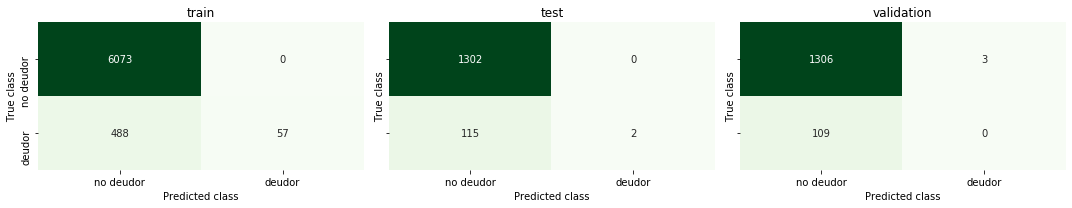

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.01088
Mejores parámetros: 
 {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 80, 'n_estimators': 50}
----------------------------------------------------------------------------------------------------------------------------


In [52]:
i = 6
experiments = [(grid_search_gb_7, pipe_gb_7), 
               (grid_search_gb_8, pipe_gb_8)] 

get_model_results(i, experiments)

<u>Resultados</u>:

En este caso, debido al desbalanceo de la variable de salida, gradient boosting no es capaz de encontrar una solución adecuada al problema por lo que creemos que debería realizarse alguna técnica de sampleo, tal como el oversampling.

### Neural Network

In [60]:
def get_neural_network_config(layer_sizes=(100,), max_iters=[200]):
    params = {
            'hidden_layer_sizes': layer_sizes,
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'max_iter': max_iters
        }
    
    model = MLPClassifier(random_state=1)
    
    return model, params

In [61]:
def make_NN_predictions(model, parameters):
    grid_search_nn = GridSearchCV(model, parameters, 
                                  scoring='f1', verbose=1)

    pipe_nn = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=1)),
        ('classifier', grid_search_nn),
    ])

    pipe_nn.fit(train, train.target)
    
    return pipe_nn, grid_search_nn

In [62]:
model_1, parameters_1 = get_neural_network_config(layer_sizes=[(80,),(90,),(100,)],
                                                  max_iters=[150,200,250])

model_2, parameters_2 = get_neural_network_config(layer_sizes=[(100,),(110,),(120,)],
                                                  max_iters=[150,200,250])

model_3, parameters_3 = get_neural_network_config(layer_sizes=[(100,),(200,),(300,)],
                                                  max_iters=[150,200,250])

pipe_nn_1, grid_search_nn_1 = make_NN_predictions(model_1, parameters_1)
pipe_nn_2, grid_search_nn_2 = make_NN_predictions(model_2, parameters_2)
pipe_nn_3, grid_search_nn_3 = make_NN_predictions(model_3, parameters_3)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_m

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\s

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't co

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_m

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\s

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum it

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\s

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum it

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 39.0min finished
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_m

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't co

**Results**

'Experiment 1'

,Accuracy,Precision,Recall,F1
train,0.948776,0.814024,0.489908,0.611684
test,0.870331,0.114943,0.085470,0.098039
validation,0.891396,0.200000,0.137615,0.163043


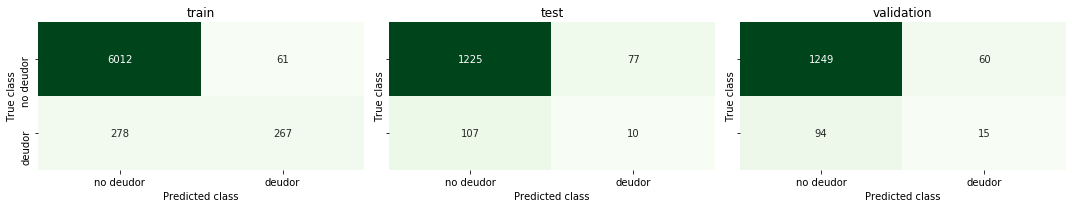

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.09364
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (80,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 2'

,Accuracy,Precision,Recall,F1
train,0.943487,0.848980,0.381651,0.526582
test,0.871741,0.077922,0.051282,0.061856
validation,0.886460,0.106061,0.064220,0.080000


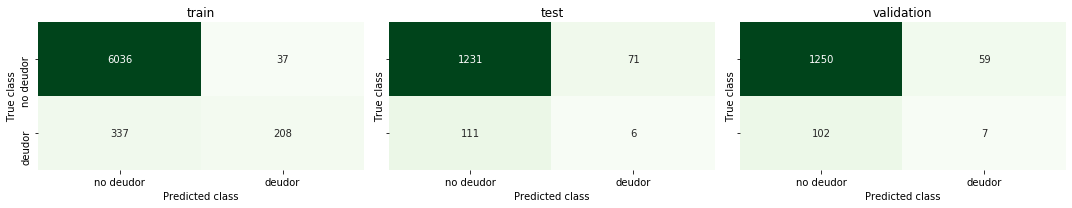

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.08507
Mejores parámetros: 
 {'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 3'

,Accuracy,Precision,Recall,F1
train,0.944092,0.869198,0.377982,0.526854
test,0.887245,0.078431,0.034188,0.047619
validation,0.889281,0.112903,0.064220,0.081871


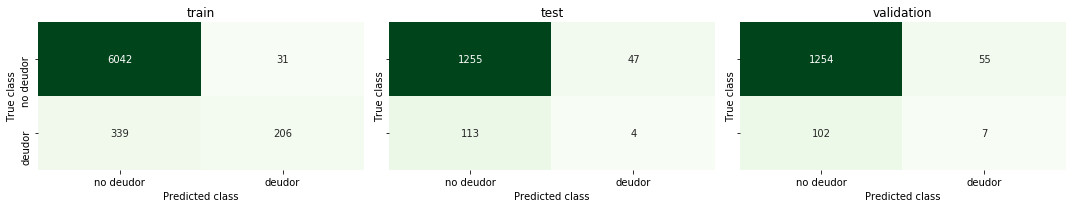

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.10527
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (300,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


In [63]:
i = 0
experiments = [(grid_search_nn_1, pipe_nn_1), 
               (grid_search_nn_2, pipe_nn_2), 
               (grid_search_nn_3, pipe_nn_3)] 

get_model_results(i, experiments)

<u>Conclusiones generales</u>:

En función de las diferentes combinaciónes probadas para redes neuronales podemos determinar que a menor número de layers mejores fueron los resultados obtenidos (esto tiene sentido basándonos en el numero de samples que tenemos para el problema). En cuanto al número de iteraciónes necesario para converger a una solución la tendencia fue a escoger una cantidad superior a la por defecto.

En base a lo dicho, vamos a probar colocar un numero menor de layers para ver como se comporta el modelo.

In [64]:
model_4, parameters_4 = get_neural_network_config(layer_sizes=[(60,),(70,),(80,)],
                                                  max_iters=[250])

model_5, parameters_5 = get_neural_network_config(layer_sizes=[(40,),(50,),(60,)],
                                                  max_iters=[250])

pipe_nn_4, grid_search_nn_4 = make_NN_predictions(model_4, parameters_4)
pipe_nn_5, grid_search_nn_5 = make_NN_predictions(model_5, parameters_5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_m

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_m

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Usuario\.conda\envs\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't co

'Experiment 4'

,Accuracy,Precision,Recall,F1
train,0.949229,0.819572,0.491743,0.614679
test,0.862579,0.093750,0.076923,0.084507
validation,0.872355,0.132653,0.119266,0.125604


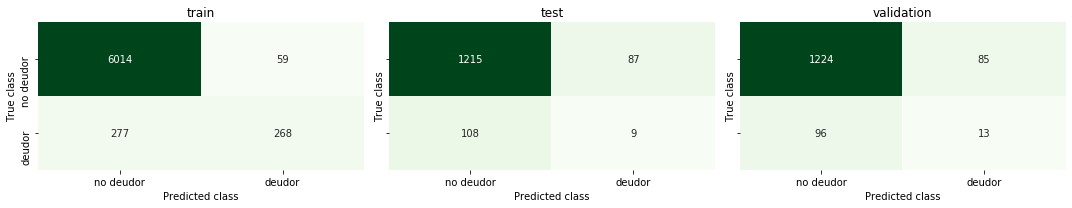

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.1114
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (60,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


'Experiment 5'

,Accuracy,Precision,Recall,F1
train,0.949229,0.819572,0.491743,0.614679
test,0.862579,0.093750,0.076923,0.084507
validation,0.872355,0.132653,0.119266,0.125604


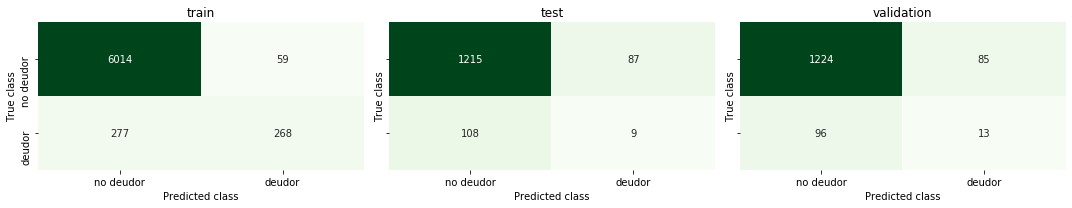

----------------------------------------------------------------------------------------------------------------------------
Mejor score (F1):  0.1114
Mejores parámetros: 
 {'activation': 'tanh', 'hidden_layer_sizes': (60,), 'max_iter': 250, 'solver': 'lbfgs'}
----------------------------------------------------------------------------------------------------------------------------


In [65]:
i = 3
experiments = [(grid_search_nn_4, pipe_nn_4), 
               (grid_search_nn_5, pipe_nn_5)] 

get_model_results(i, experiments)

En base a estos resultados podemos determinar que el mejor número de layers para la red neuronal es de 80, ya que estos 2 ultimos experimentos no mejoran con relación al experimento 1.

<u>Resultados</u>:
* El precission alcanzado por el experimento 1 (el "mejor") es de %0.11
* No obstante, recall es de apenas un ≈8%.
* Este recall tan bajo nos lleva a tener un F1 de apenas 0.10 aprox.

# Conclusiones finales

Ninguno de los modelos testeados logra una performance destacable (no se supera el 12% en precission ni el 20% en F1-score). En función de esto, la elección de el "mejor modelo" resulta un tanto superflua debido a la poca variabilidad en los resultados. A su vez, debemos tener en cuenta que es lo que mas le interesa al cliente a la hora de la elección del modelo, resultando conveniente la organización de reuniones incrementales para análisis de resultados.

Mas allá de esto, consideramos que el "mejor modelo" de los evaluados es Random Forest (experimento 3), debido a que es el que mantiene una relacion mas balanceada entre los positivos encontrados y los negativos. Sin embargo, otros modelos como Decission Tree y Logistic Regression arrojan resultados muy similares en algunas de sus configs.

# Trabajo Futuro

* Nuestro objetivo central debería ser conseguir mas información. En esto recae el progreso que podamos ver en los modelos, en otras palabras, es mucho mas el terreno que podemos ganar realizando análisis y feature engineering con nuevas versiones del dataset que tuneando hiperparámetros.

* Volver a correr los presentes experimentos utilizando otras técnicas para encoding de variables categóricas tales como "leave one out" o "target encoder".

* Definir con el cliente el tresh old entre precission y recall, ¿Que le interesa mas? ¿Cual es el umbrál para clasificar el resultado de un modelo como útil?

* Probar otros modelos.

* Entrenar redes neuronales con Keras, utilizando TensorFlow como backend, facilitando el tunning de hiperparámetros.

* Plotear y analizar las curvas de aprendizaje.